Gaussian processes (GP) are a cornerstone of modern machine learning. They are often used for *non-parametric* regression and classification, and are extended from the theory behind Gaussian distributions and Gaussian mixture models (GMM), with strong and interesting theoretical ties to kernels and neural networks. While Gaussian mixture models are used to represent a distribution over values, ***Gaussian processes are a distribution over functions***. This is easy enough to say, but what does it really mean? Let's take a look.
<!-- TEASER_END -->

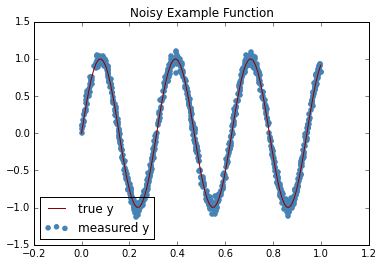

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.RandomState(1999)
n_samples = 1000
X = rng.rand(n_samples)
y = np.sin(20 * X) + .05 * rng.randn(X.shape[0])
X_t = np.linspace(0, 1, 100)
y_t = np.sin(20 * X_t)
plt.scatter(X, y, color='steelblue', label='measured y')
plt.plot(X_t, y_t, linestyle='-', color='darkred', label='true y')
plt.title('Noisy Example Function')
plt.legend(loc='lower left')

Here we have a set of values, $X$, and another set of values $y$. The values of $X$ are related to $y$ by a function $f(x)$, which is described by the equation $y = sin(C * X) + \varepsilon$, where $\varepsilon$ is some noise (in this case Gaussian noise with a variance of .05) and $C$ is some constant (in this case, 20, increasing the frequency of the oscillations so things look nice). 

This means that for any value $x$ we put into the function, we get out some new value $y$. If we did not know $f(x)$, and were only given $X$ and $y$, we would be very interested in learning $f(x)$ from the data. If we learned it perfectly, then we would be able to ***accurately predict*** any new $y$ given an input $x$. 

This may not seem exciting, because this particular $f(x)$ is ***boring***. But imagine our $f(x)$ is something complicated, like a price on the stock market, or energy demand, or the probability of being struck be lightning at a given a location... it becomes a lot more interesting to learn $f(x)$ from data! This is the general motivation behind *many* machine learning tasks, but this definition of learning the "most likely generating function" has a special importance for the Gaussian process.

In the plot above, the blue values represent data that has been measured, while the red value indicates the true generating function. We can see that the red values are the *mean* of this particular function, while the errors *around* the red line (where the blue points fall) represents the *covariance* of this particular function.

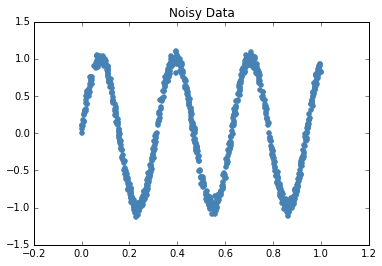

In [2]:
rng = np.random.RandomState(1999)
n_samples = 1000
X = rng.rand(n_samples)
y = np.sin(20 * X) + .05 * rng.randn(X.shape[0])
plt.scatter(X, y, color='steelblue')
plt.title('Noisy Data')

Now imagine a case like the above, where the red line values are *unknown*. We have points $X$, and measurements from those points $y$. We can also look at the graph and approximate the red line from the previous graph running through the center of the blue points. If we do this procedure in a mathematical way, we are *learning* $f(x)$ from the data!

This is basically how estimating the *mean* function as a Gaussian processes works - given a set of existing points, we have mathematical tools for estimating the *mean* and *covariance* function for this particular set of data. We are also able to use our prior information (things like: this function repeats, $X$ values near each other generate $y$ values near each other, etc.) by picking certain formulas to use for the *covariance function* during the estimation process.

However, there is a problem - if our measurements are very noisy it may be very difficult (or impossible!) to figure out $f(x)$. 

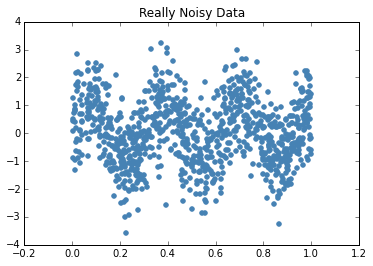

In [3]:
rng = np.random.RandomState(1999)
n_samples = 1000
X = rng.rand(n_samples)
y = np.sin(20 * X) + .95 * rng.randn(n_samples)
plt.scatter(X, y, color='steelblue')
plt.title('Really Noisy Data')

Looking at the above plot, it is easy to see that generating the "red line" like above would be much more difficult, even though the generating function $sin()$ is the same. In a sense, you could say that the **distribution of possible functions** to generate those $y$ values from $X$ is very wide, and it is hard to find the "best guess" for $f(x)$.

Well Isn't That Special
-----------------------
This is exactly what is meant by ***Gaussian processes are distributions over functions***. Like a regular Gaussian distribution (or multivariate Gaussian) which is fully defined by it's mean and covariance, a Gaussian process is fully defined by it's **mean function** $m(x)$ and **covariance function** $K(x, x')$. 

This covariance function (also called a kernel or correlation function in a bunch of other literature!) gives the pairwise distance between all combinations of points. I will use the name **covariance function** from here on, but it is important to know that covariance function, correlation function, and kernel function are used semi-interchangeably in the existing papers and examples! My thought is that a covariance function uses a kernel function to compute the variance in some kernel space - so you will see a function name covariance that takes a kernel argument later in the code. A great link on this (courtesy of mcoursen) is [here](http://www.rle.mit.edu/rgallager/documents/6.262vcpw3.pdf). Lets walk through a simple example, modified from [Christopher Fonnesbeck's code for Bios366](http://nbviewer.ipython.org/github/fonnesbeck/Bios366/blob/master/notebooks/Section5_1-Gaussian-Processes.ipynb).

We will need to start with some "initial guess" for both the mean function and the covariance function. The simplest guess is 0 mean, with some covariance defined by taking our ***kernel function*** at $0$. Though there are many different kernel functions, the exponential kernel is usually one of the first to try. I will be covering kernels in more detail in both this post and a followup, but to keep things simple we will gloss over the details.

Ultimately, a kernel is simply a function that takes in two matrices (or vectors) and compares the distances between every sample in some space. In a linear space, this is as simple as *np.dot(x, x.T)* if x is a rows-as-samples matrix. The exponential kernel measures distances in a non-linear space, defined by a Gaussian transformation. This sounds pretty complicated, but thinking of these kernels as *black box* functions that return distances between samples is good enough to get through this post. 

Our initial mean function is simply $0$, and the correlation function gives an initial condition by calculating *covariance(kernel, 0, 0)*. Using this as a starting place, we can visualize our initial function estimate, given no information besides a choice for the kernel.

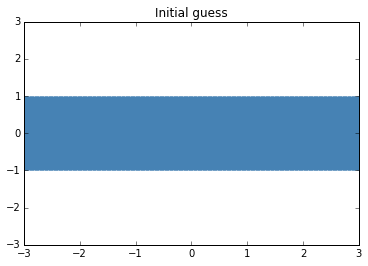

In [4]:
# from mrmartin.ner/?p=223
def exponential_kernel(x1, x2):
    # Broadcasting tricks to get every pairwise distance.
    return np.exp(-(x1[np.newaxis, :, :] - x2[:, np.newaxis, :])[:, :, 0] ** 2).T

# Covariance calculation for a given kernel
def covariance(kernel, x1, x2):
    return kernel(x1, x2)

rng = np.random.RandomState(1999)

# Initial guess
kernel = exponential_kernel
init = np.zeros((1, 1))
sigma = covariance(kernel, init, init)
xpts = np.arange(-3, 3, step=0.01).reshape((-1, 1))
plt.errorbar(xpts.squeeze(), np.zeros(len(xpts)), yerr=sigma.squeeze(),
             capsize=0, color='steelblue')
plt.ylim(-3, 3)
plt.title("Initial guess")

Now that we have initialized the GP, we want to estimate a new $y$ given a new input $x$. Without any prior knowledge our guess will not be very good, which is represented by the wide blue line across the plot (our *confidence bounds*). Luckily, we have a set of $x$ values that are paired with $y$ values , called our *training set*, which we can use to learn a possible model. To make these updates, we will need a new tool: the **conditional distribution**.

The conditional formula is fairly straightforward mathematically, and is seen in many other works. For a full derivation, see the [slides here](https://cs.nyu.edu/~mirowski/pub/CBLL_5May2009_GaussianProcessDynamicalModels.pdf) or the [tutorial here](http://www.robots.ox.ac.uk/~mebden/reports/GPtutorial.pdf). I will simply state the key mathematics, and show code to compute it.

Conditionals of My Parole
-------------------------
One of the key formulas for the Gaussian process is the conditional function for multivariate Gaussian distributions. This is quite a mouthful, but the idea boils down to "Given my old x, and the y values for those x, what do I expect a new y to be?". 

If we have no data, we have no idea what y can be. With a lot of data in a given region, we start to have a pretty strong intuition about y when given an x. 

    x = 3, what is y?
    
**I have no idea, and this is a terrible question**

We are then given the following information:

    x = 1, y = 2
    x = 2, y = 4
    x = 4, y = 8
    x = 5, y = 10 

Now, if asked again, what is your best guess for $y$?


    x = 3, what is y?

**My best guess would be $y = 6$**


Technically, $y$ could be *anything* but judging by the past results, $y = 6$ seems to be a reasonable guess.

The mathematical formula for this *conditional distibution*, with some Gaussian assumptions (this *is* assumed to be a Gaussian process after all) is shown below.

$p(\hat{x}|x,y) = \mathcal{N}(\mu_\hat{x} + \Sigma_{x\hat{x}}\Sigma_{x}^{-1}(y - \mu_{y}), 
\Sigma_\hat{x}-\Sigma_{x\hat{x}}\Sigma_x^{-1}\Sigma_{x\hat{x_n}}^T)$

The new input value is $\hat{x}$, with the previous x and y values being $x$ and $y$. Since we typically assume $\mu_x$ and $\mu_y$ are both $0$, this equation can be simplified.

$p(\hat{x}|x,y) = \mathcal{N}( \Sigma_{x\hat{x}}\Sigma_{x}^{-1}y, 
\Sigma_\hat{x}-\Sigma_{x\hat{x}}\Sigma_x^{-1}\Sigma_{x\hat{x_n}}^T)$

The conditional function below is the coded representation of this. Let's use it to make some plots of Gaussian process learning.

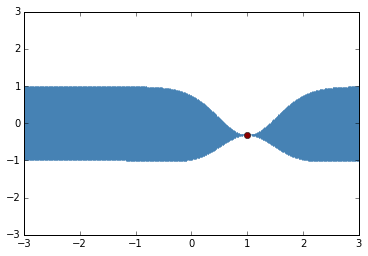

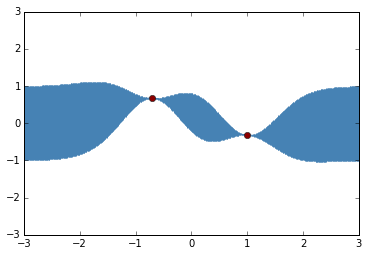

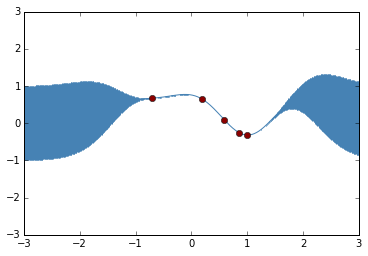

In [5]:
def conditional(x_new, x, y, kernel):
    cov_xxn = covariance(kernel, x_new, x)
    cov_x = covariance(kernel, x, x)
    cov_xn = covariance(kernel, x_new, x_new)
    mean = cov_xxn.dot(np.linalg.pinv(cov_x)).dot(y) 
    variance = cov_xn - cov_xxn.dot(np.linalg.pinv(cov_x)).dot(cov_xxn.T)
    return mean, variance


# First point estimate
x_new = np.atleast_2d(1.)
# No conditional, this is the first value!
y_new = np.atleast_2d(0 + rng.randn())
x = x_new
y = y_new

# Plotting
y_pred, sigma_pred = conditional(xpts, x, y, kernel=kernel)
plt.errorbar(xpts.squeeze(), y_pred.squeeze(), yerr=np.diag(sigma_pred),
             capsize=0, color='steelblue')
plt.plot(x, y, color='darkred', marker='o', linestyle='')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.figure()

# Second point estimate
x_new = np.atleast_2d(-0.7)
mu, s = conditional(x_new, x, y, kernel=kernel)
y_new = np.atleast_2d(mu + np.diag(s)[:, np.newaxis] * rng.randn(*x_new.shape))
x = np.vstack((x, x_new))
y = np.vstack((y, y_new))

# Plotting
y_pred, sigma_pred = conditional(xpts, x, y, kernel=kernel)
plt.errorbar(xpts.squeeze(), y_pred.squeeze(), yerr=np.diag(sigma_pred),
             capsize=0, color='steelblue')
plt.plot(x, y, color='darkred', marker='o', linestyle='')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.figure()

# Multipoint estimate
x_new = rng.rand(3, 1)
mu, s = conditional(x_new, x, y, kernel=kernel)
y_new = mu + np.diag(s)[:, np.newaxis] * rng.randn(*x_new.shape)
x = np.vstack((x, x_new))
y = np.vstack((y, y_new))

# Plotting
y_pred, sigma_pred = conditional(xpts, x, y, kernel=kernel)
plt.errorbar(xpts.squeeze(), y_pred.squeeze(), yerr=np.diag(sigma_pred),
             capsize=0, color='steelblue')
plt.plot(x, y, color='darkred', marker='o', linestyle='')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

We can see from the above plots that we have a pretty good idea of the values we would get out of the function given $x = 1$. It is less clear what values we would get for $x = 3$, and only gets worse as we travel off the plot.

Our *expected value* for the function is simply the mean we get out of the conditional, and the returned variance measures our uncertainty in the answer.

In [6]:
mean, var = conditional(np.array([[1]]), x, y, kernel=kernel)
print("Expected value for x = %i, %.4f" % (1, mean))
print("Uncertainty %.4f" % var)
print()

mean, var = conditional(np.array([[3]]), x, y, kernel=kernel)
print("Expected value for x = %i, %.4f" % (3, mean))
print("Uncertainty %.4f" % var)
print()

mean, var = conditional(np.array([[1E6]]), x, y, kernel=kernel)
print("Expected value for x = %i, %.4f" % (1E6, mean))
print("Uncertainty %.4f" % var)
print()

Expected value for x = 1, -0.3175
Uncertainty 0.0000

Expected value for x = 3, 0.1262
Uncertainty 0.9913

Expected value for x = 1000000, 0.0000
Uncertainty 1.0000



The numerical results above agree with our intuition looking at the final plot.

It is clear that adding more measured points in a region increases our ability to predict new values in that region - this is the heart of the Gaussian process. Given enough data points, it is possible to have strong prediction ability for many different functions.

We also have the ability to encode *prior knowledge* about the function generating the data using different kernel functions. There are many, many, many kernel functions which are used in machine learning, and I plan to further cover kernels in general in a follow-up post. Just know that the exponential kernel is a good default choice, though that kernel also has many parameters to tune! This gets into *model selection* or *hyperparameter optimization* which is also a topic for another day.

This is all great, but the code is kind of a mess. Let's clean up this code and make a simple, scikit-learn style regression estimator, saving classification for another day.

In [7]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from scipy import linalg
from sklearn.utils import check_array
import matplotlib.pyplot as plt

def plot_gp_confidence(gp, show_gp_points=True, X_low=-1, X_high=1,
                       X_step=.01, xlim=None, ylim=None):
    xpts = np.arange(X_low, X_high, step=X_step).reshape((-1, 1))
    try:
        y_pred = gp.predict(xpts)
        mean = gp.predicted_mean_
        var = gp.predicted_var_
        if gp.predicted_mean_.shape[1] > 1:
            raise ValueError("plot_gp_confidence only works for 1 dimensional Gaussian processes!")
        rng = np.random.RandomState(1999)
        y_new = mean + np.diag(var)[:, np.newaxis] * rng.randn(*xpts.shape)
    except TypeError:
        y_pred = xpts * 0
        var = gp.predicted_var_ * np.ones((xpts.shape[0], xpts.shape[0]))
        
    plt.errorbar(xpts.squeeze(), y_pred.squeeze(), yerr=np.diag(var),
                 capsize=0, color='steelblue')
    if show_gp_points:
        plt.plot(gp._X, gp._y, color='darkred', marker='o', linestyle='')
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    plt.show()

# from mrmartin.ner/?p=223
def exponential_kernel(x1, x2):
    # Broadcasting tricks to get every pairwise distance.
    return np.exp(-(x1[np.newaxis, :, :] - x2[:, np.newaxis, :])[:, :, 0] ** 2).T

class SimpleGaussianProcessRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, kernel_function, copy=True):
        self.kernel_function = kernel_function
        self.copy = copy
        self.predicted_mean_ = 0
        self.predicted_var_ = self._covariance(np.zeros((1, 1)), np.zeros((1, 1)))
        self._X = None
        self._y = None
        
    def _covariance(self, x1, x2):
        return self.kernel_function(x1, x2)
    
    def fit(self, X, y):
        self._X = None
        self._y = None
        return self.partial_fit(X, y)
    
    def partial_fit(self, X, y):
        X = check_array(X, copy=self.copy)
        y = check_array(y, copy=self.copy)
        if self._X is None:
            self._X = X
            self._y = y
        else:
            self._X = np.vstack((self._X, X))
            self._y = np.vstack((self._y, y))
        
    def predict(self, X, y=None):
        X = check_array(X, copy=self.copy)
        cov_xxn = self._covariance(X, self._X)
        cov_x = self._covariance(self._X, self._X)
        cov_xn = self._covariance(X, X)
        cov_x_inv = linalg.pinv(cov_x)
        mean = cov_xxn.dot(cov_x_inv).dot(self._y) 
        var = cov_xn - cov_xxn.dot(cov_x_inv).dot(cov_xxn.T)
        self.predicted_mean_ = mean
        self.predicted_var_ = var
        return mean

Classy
------
Now we have a proper scikit-learn style class, and a plot helper to visualize things easily. We can now test the $sin()$ function from the start of this blog post quite easily.

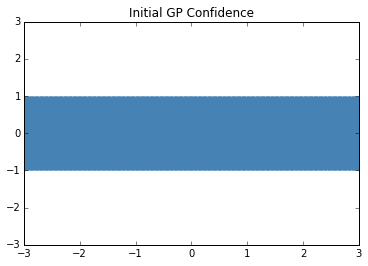

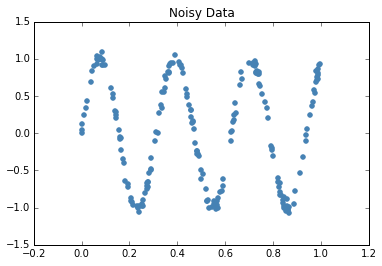

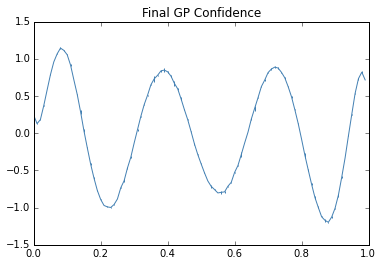

In [8]:
gp = SimpleGaussianProcessRegressor(exponential_kernel)
plt.title('Initial GP Confidence')
plot_gp_confidence(gp, X_low=-3, X_high=3, X_step=.01,
                   xlim=(-3, 3), ylim=(-3, 3))

rng = np.random.RandomState(1999)
n_samples = 200
X = rng.rand(n_samples, 1)
y = np.sin(20 * X) + .05 * rng.randn(X.shape[0], 1)
plt.title('Noisy Data')
plt.scatter(X, y, color='steelblue')
plt.show()

gp.fit(X, y)
X_new = rng.rand(5, 1)
gp.predict(X_new)
plt.title('Final GP Confidence')
plot_gp_confidence(gp, show_gp_points=False, X_low=0, X_high=1, X_step=.01)

To Boldly Go...
---------------
Though the results are not perfect, the *SimpleGaussianProcessRegressor* has done a good job approximating the low noise $sin()$ function. It could probably get a better fit if we changed the kernel function, but that is a story for another time. What if we feed it the extremely noisy data?

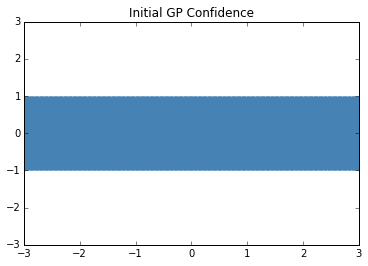

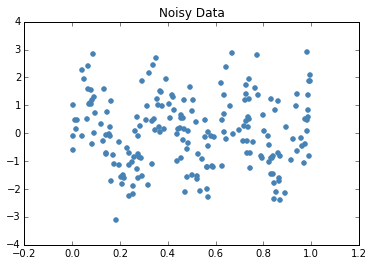

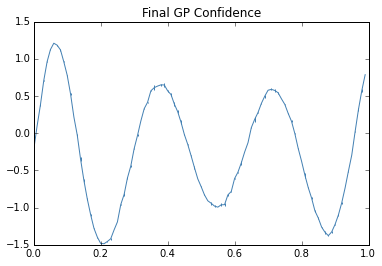

In [9]:
gp = SimpleGaussianProcessRegressor(exponential_kernel)
plt.title('Initial GP Confidence')
plot_gp_confidence(gp, X_low=-3, X_high=3, X_step=.01,
                   xlim=(-3, 3), ylim=(-3, 3))

rng = np.random.RandomState(1999)
n_samples = 200
X = rng.rand(n_samples, 1)
y = np.sin(20 * X) + .95 * rng.randn(X.shape[0], 1)
plt.title('Noisy Data')
plt.scatter(X, y, color='steelblue')
plt.show()

gp.fit(X, y)
X_new = rng.rand(5, 1)
gp.predict(X_new)
plt.title('Final GP Confidence')
plot_gp_confidence(gp, show_gp_points=False, X_low=0, X_high=1, X_step=.01)

Not that great, but it still shows some cyclic trends and is definitely better than predicting the mean only. The astute reader will also note that I reduced the number of samples for both of these tests. This is because the naive implementation of Gaussian processes is *slow*. As implemented, this algorithm is $O(n^3)$) due to the matrix inversion function (linalg.pinv). There are $O(nlog(n))$ methods for Gaussian processes, but they require advanced solvers and a few other tricks.

For further reading on the subject of Gaussian processes, [GPML](http://www.gaussianprocess.org/gpml/chapters/RW.pdf) is an excellent book authored by two of the preeminent researchers in the field. I plan to cover classification, kernels, and more tricks for *fast* Gaussian process learning in an upcoming post.

kk